## Final Project Submission

- Student name: Jack Locke
- Student pace: Self-paced
- Instructor name: Mark Barbour

# Movie Studio Data Analysis

## Overview

- 1. Business Understanding
- 2. Data Understanding
- 3. Data Preparation
    - a. Merging Datasets
    - b. Filtering Repeated Rows
    - c. Dropping Unnecessary Columns
    - d. Primary Columns Information
    - e. Cleaning Primary Columns
    - f. Creating Additional Columns for Analysis
- 4. Exploratory Data Analysis
    - a. Genre vs. ROI
    - b. Month vs. ROI
    - c. Director vs. ROI
- 5. Conclusions
    - a. Limitations
    - b. Recommendations
- 6. Next Steps

## Business Understanding

The business stakeholder is a company creating a new movie studio because they want to break into the film industry. My project analyzes films based on box office performance data. The aim is to find patterns and trends within the data in order to provide recommendations for what filmmakers should focus on when creating films for their new movie studio. I will focus on recommending what genres, release dates, and directors will best suit the stakeholder's business when compared to their respective ROIs (return on investment). The recommendations will help the business create films that will lead to profit for the company. My analysis will use the CRISP-DM (Cross-industry standard process for data mining) methodology. 

## Data Understanding

For this project, I am working with datasets from two different resources. One dataset is from IMDB’s relational database. I will gather data about movie genres and their directors from this database. The genre and director information will come from two different tables within the relational database. The final dataset contains information on roughly 160,000 movies. 

The other dataset comes from a CSV file called Movie Budgets. This dataset contains information on movie release dates and finances, such as production budget and gross revenue. The dataset contains information on roughly 5,800 movies. 

The link attached will guide you to a github account containing the IMDB database and Movie Budgets CSV file with IMDB’s respective ERD (Entity Relationship Diagram), if you wish to clone the repository and view the data: https://github.com/learn-co-curriculum/dsc-phase-2-project-v3/tree/main/zippedData

In [4275]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
%matplotlib inline
import re
import matplotlib.patches as mpatches
import statistics

In [4276]:
conn = sqlite3.Connection('data/im.db')
imdb_df = pd.read_sql("""

SELECT primary_title, runtime_minutes, genres, start_year, movie_id
FROM movie_basics
;""",conn)
imdb_df.head()

,primary_title,runtime_minutes,genres,start_year,movie_id
0,Sunghursh,175.0,"Action,Crime,Drama",2013,tt0063540
1,One Day Before the Rainy Season,114.0,"Biography,Drama",2019,tt0066787
2,The Other Side of the Wind,122.0,Drama,2018,tt0069049
3,Sabse Bada Sukh,NaN,"Comedy,Drama",2018,tt0069204
4,The Wandering Soap Opera,80.0,"Comedy,Drama,Fantasy",2017,tt0100275


In [4277]:
director_df = pd.read_sql("""

SELECT DISTINCT movie_id, person_id, primary_name
FROM directors
JOIN persons
USING(person_id)


;""",conn)
director_df.head()

,movie_id,person_id,primary_name
0,tt0285252,nm0899854,Tony Vitale
1,tt0462036,nm1940585,Bill Haley
2,tt0835418,nm0151540,Jay Chandrasekhar
3,tt0878654,nm0089502,Albert Pyun
4,tt0878654,nm2291498,Joe Baile


In [4278]:
tn_df = pd.read_csv('data/tn.movie_budgets.csv.gz')
tn_df.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


## Data Preparation

 - Merging Datasets together into one combined dataframe
 - After merging the dataset we will deal with repeated rows
 - Drop the unnecessary columns from our dataframe
 - Get information on our primary columns
 - Clean the dataframe
 - Create columns needed for our EDA

### Merging datasets

I currently have three datasets: two from the IMBD database and one from the Movie Budget CSV file. Our recommendations require all datasets to be combined into one dataframe, as I will need to compare what the stakeholders can control with the financial data.

In [4279]:
director_movie_df = director_df.merge(imdb_df, on='movie_id', how = 'inner')
director_movie_df.head()

,movie_id,person_id,primary_name,primary_title,runtime_minutes,genres,start_year
0,tt0285252,nm0899854,Tony Vitale,Life's a Beach,100.0,Comedy,2012
1,tt0462036,nm1940585,Bill Haley,Steve Phoenix: The Untold Story,110.0,Drama,2012
2,tt0835418,nm0151540,Jay Chandrasekhar,The Babymakers,95.0,Comedy,2012
3,tt0878654,nm0089502,Albert Pyun,Bulletface,82.0,Thriller,2010
4,tt0878654,nm2291498,Joe Baile,Bulletface,82.0,Thriller,2010


In [4280]:
tn_df['movie'] = tn_df['movie'].apply(lambda x: x.lower())
director_movie_df['primary_title'] = director_movie_df['primary_title'].apply(lambda x: x.lower())

In [4281]:
combined_df = tn_df.merge(director_movie_df, left_on='movie', right_on='primary_title', how = 'inner')

In [4282]:
# length of dataframe is longer than length of tn_df that we merged on meaning there are multiple primary_titles
# that match the movie titles. Essentially duplicated names; movies with same name. We need to figure out how to
# make sure we are using the right ones and we can do that by matching start_year with release date_year. This
# will not be perfect as dups can have the same year potentially but it will greatly reduce this number for us. 
# Also, some movies might have the same name but not be referring to the same movie, for example avatar is not a
# horror movie and doing further research you see there is an older movie also called avatar. 
combined_df.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,movie_id,person_id,primary_name,primary_title,runtime_minutes,genres,start_year
0,1,"Dec 18, 2009",avatar,"$425,000,000","$760,507,625","$2,776,345,279",tt1775309,nm3786927,Atsushi Wada,avatar,93.0,Horror,2011
1,2,"May 20, 2011",pirates of the caribbean: on stranger tides,"$410,600,000","$241,063,875","$1,045,663,875",tt1298650,nm0551128,Rob Marshall,pirates of the caribbean: on stranger tides,136.0,"Action,Adventure,Fantasy",2011
2,3,"Jun 7, 2019",dark phoenix,"$350,000,000","$42,762,350","$149,762,350",tt6565702,nm1334526,Simon Kinberg,dark phoenix,113.0,"Action,Adventure,Sci-Fi",2019
3,4,"May 1, 2015",avengers: age of ultron,"$330,600,000","$459,005,868","$1,403,013,963",tt2395427,nm0923736,Joss Whedon,avengers: age of ultron,141.0,"Action,Adventure,Sci-Fi",2015
4,7,"Apr 27, 2018",avengers: infinity war,"$300,000,000","$678,815,482","$2,048,134,200",tt4154756,nm0751577,Anthony Russo,avengers: infinity war,149.0,"Action,Adventure,Sci-Fi",2018


### Filtering repeated rows

When I merged the datasets on the movie titles, I discovered some movies have duplicate titles. I do not want financial data to be linked to the incorrect movie titles, skewing our results. To fix this, I will use the 'release_date' column and create a new column, 'matching_year'. I can then compare ‘matching_year’ with the 'start_year' column. This will help match the correct movies with the proper financial data. This will not be perfect as there will be movies with duplicate titles also released in the same year. But, this will significantly reduce our issue. The number of movies released the same year with duplicate titles is small. I am also using median values for my recommendations, so this small number of rows I cannot filter out will not significantly impact our results. 

In [4283]:
combined_df['matching_year'] = combined_df['release_date'].apply(lambda x: x[-4:]).astype(float)

In [4284]:
combined_df = combined_df[(combined_df['start_year'] == combined_df['matching_year'])]

In [4285]:
combined_df

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,movie_id,person_id,primary_name,primary_title,runtime_minutes,genres,start_year,matching_year
1,2,"May 20, 2011",pirates of the caribbean: on stranger tides,"$410,600,000","$241,063,875","$1,045,663,875",tt1298650,nm0551128,Rob Marshall,pirates of the caribbean: on stranger tides,136.0,"Action,Adventure,Fantasy",2011,2011.0
2,3,"Jun 7, 2019",dark phoenix,"$350,000,000","$42,762,350","$149,762,350",tt6565702,nm1334526,Simon Kinberg,dark phoenix,113.0,"Action,Adventure,Sci-Fi",2019,2019.0
3,4,"May 1, 2015",avengers: age of ultron,"$330,600,000","$459,005,868","$1,403,013,963",tt2395427,nm0923736,Joss Whedon,avengers: age of ultron,141.0,"Action,Adventure,Sci-Fi",2015,2015.0
4,7,"Apr 27, 2018",avengers: infinity war,"$300,000,000","$678,815,482","$2,048,134,200",tt4154756,nm0751577,Anthony Russo,avengers: infinity war,149.0,"Action,Adventure,Sci-Fi",2018,2018.0
5,7,"Apr 27, 2018",avengers: infinity war,"$300,000,000","$678,815,482","$2,048,134,200",tt4154756,nm0751648,Joe Russo,avengers: infinity war,149.0,"Action,Adventure,Sci-Fi",2018,2018.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4229,45,"Jan 27, 2017",emily,"$27,000","$3,547","$3,547",tt4393036,nm6254824,Ryan Graves,emily,83.0,Drama,2017,2017.0
4231,49,"Sep 1, 2015",exeter,"$25,000",$0,"$489,792",tt1945044,nm1197971,Marcus Nispel,exeter,91.0,"Horror,Mystery,Thriller",2015,2015.0
4237,52,"Dec 1, 2015",dutch kills,"$25,000",$0,$0,tt2759066,nm3556672,Joseph Mazzella,dutch kills,90.0,"Crime,Drama,Thriller",2015,2015.0
4241,59,"Nov 25, 2011",the ridges,"$17,300",$0,$0,tt1781935,nm4192760,Brandon Landers,the ridges,89.0,"Drama,Horror,Thriller",2011,2011.0


### Dropping Unnecessary Columns

In [4286]:
#Will be removing other columns as we progress; create drop function for reusability
def drop(cols,df):
    '''Is going to take the column name and apply the drop function'''
    for x in cols:
        df.drop(columns=x, inplace=True)

In [4287]:
drop(['id','primary_title', 'start_year', 'matching_year','domestic_gross', 'movie_id', 'person_id'], combined_df)


### Primary Columns Information

Want to view what the stakeholders can control:
- Release dates
- Genres
- Directors

With measurements of success (used to create Gross Profit and Gross ROI):
- Production budget
- Gross Revenue

In [4288]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1747 entries, 1 to 4242
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   release_date       1747 non-null   object 
 1   movie              1747 non-null   object 
 2   production_budget  1747 non-null   object 
 3   worldwide_gross    1747 non-null   object 
 4   primary_name       1747 non-null   object 
 5   runtime_minutes    1721 non-null   float64
 6   genres             1742 non-null   object 
dtypes: float64(1), object(6)
memory usage: 109.2+ KB


In [4289]:
combined_df['release_date'].value_counts()

release_date
Dec 31, 2014    17
Jan 25, 2013    15
Dec 31, 2010    11
Sep 23, 2011    10
Dec 31, 2015    10
                ..
Mar 29, 2018     1
Mar 22, 2019     1
Jan 18, 2019     1
Nov 16, 2011     1
Jan 27, 2017     1
Name: count, Length: 622, dtype: int64

In [4290]:
combined_df['movie'].value_counts()

movie
movie 43                13
freakonomics             6
the promise              5
locker 13                5
redemption               4
                        ..
only the brave           1
rush                     1
the 5th wave             1
riddick                  1
stories of our lives     1
Name: count, Length: 1525, dtype: int64

In [4291]:
combined_df['genres'].value_counts()

genres
Adventure,Animation,Comedy    107
Comedy                         81
Drama                          69
Action,Adventure,Sci-Fi        58
Comedy,Drama,Romance           57
                             ... 
Adventure,Comedy,Romance        1
Comedy,Sci-Fi                   1
Comedy,Drama,Sport              1
Adventure,Comedy,Sci-Fi         1
Comedy,Horror,Thriller          1
Name: count, Length: 235, dtype: int64

In [4292]:
combined_df['primary_name'].value_counts()

primary_name
Tim Story            8
Steven Spielberg     7
Clint Eastwood       7
Jon M. Chu           6
Ridley Scott         6
                    ..
Billy Ray            1
James Mather         1
Steve Saint Leger    1
Mark Mylod           1
Jim Chuchu           1
Name: count, Length: 1187, dtype: int64

In [4293]:
combined_df['worldwide_gross'].value_counts()

worldwide_gross
$0              136
$31,164,747      13
$172,867          6
$3,496            5
$10,551,417       5
               ... 
$41,294,674       1
$101,162,106      1
$95,989,590       1
$126,069,509      1
$489,792          1
Name: count, Length: 1407, dtype: int64

In [4294]:
combined_df['production_budget'].value_counts()

production_budget
$10,000,000    79
$20,000,000    74
$30,000,000    56
$5,000,000     55
$40,000,000    52
               ..
$19,500,000     1
$19,200,000     1
$19,100,000     1
$17,700,000     1
$15,000         1
Name: count, Length: 261, dtype: int64

### Cleaning Primary Columns 

After viewing our primary columns, I will need to change 'production_budget' and 'worldwide_gross'(gross revenue) into integer datatypes so I can create additional columns for measurements. Additionally, there are missing values in 'runtime_minutes' and 'genres' that need to be filled in. 

In [4295]:
def money_values(lst):
    for df in lst:
        combined_df[df] = combined_df[df].apply(lambda x: re.sub(r'[^\w\s]', '', x))
        combined_df[df] = combined_df[df].apply(int)

In [4296]:
monetary_columns_lst = ['production_budget', 'worldwide_gross']
money_values(monetary_columns_lst)

In [4297]:
combined_df['runtime_minutes'] = combined_df['runtime_minutes'].fillna(combined_df['runtime_minutes'].mean())
combined_df = combined_df[combined_df['runtime_minutes']>30]
drop(['runtime_minutes'],combined_df)

<ipython-input-4286-9bb459816f07>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=x, inplace=True)


In [4298]:
combined_df.reset_index(drop=True, inplace=True)

In [4299]:
def missing_genre(index, typ):
    'Will take the dataframe index and set the genre to its specific type'
    combined_df.loc[index,'genres'] = typ

In [4300]:
missing_genre(32,'Action,Adventure')
missing_genre(515,'Comedy,Action')
missing_genre(516,'Comedy,Action')
missing_genre(996,'Action,Thriller')
missing_genre(1115,'Drama')

### Creating Additional Columns for Analysis

My EDA will be looking into the best release dates based on their months. I will need to use the 'release_date' column to create a new column for the month it was released, 'month'. 

Additionally, I will be creating a ROI column as a success measurement. I will need to take 'worldwide_gross' and subtract 'production_budget' to create a new column, 'gross_profit'. From there, I can take 'gross_profit' and divide it by 'production_budget', multiply it by 100, to get the 'gross_roi' percentage. The 'gross_roi' column will be what I use as my measurement of success. 

In [4301]:
combined_df['month'] = combined_df['release_date'].apply(lambda x: x[:3])

<ipython-input-4301-5f98bcda6572>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_df['month'] = combined_df['release_date'].apply(lambda x: x[:3])


In [4302]:
drop(['release_date'],combined_df)

<ipython-input-4286-9bb459816f07>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=x, inplace=True)


In [4303]:
combined_df['gross_profit'] = combined_df.apply(lambda x: x['worldwide_gross'] - x['production_budget'], axis=1)

<ipython-input-4303-4851ec5c6925>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_df['gross_profit'] = combined_df.apply(lambda x: x['worldwide_gross'] - x['production_budget'], axis=1)


In [4304]:
combined_df['gross_roi'] = combined_df.apply(lambda x: round((x['gross_profit'] / x['production_budget'])*100,2), 
                                             axis=1)

<ipython-input-4304-8ab93ed773e4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_df['gross_roi'] = combined_df.apply(lambda x: round((x['gross_profit'] / x['production_budget'])*100,2),


## Exploratory Data Analysis

As mentioned in previous sections, I will explore what the stakeholders can control with my created measurement of success. I will examine which genres, months, and directors are the most highly represented. I will need additional data engineering to show my results graphically. I will view the relationships with bar graphs as this will best show us the most highly represented values. I will be looking at the median gross ROI values. Extreme outliers are present in the data, so using the mean will lead to highly skewed results. I will use the median to accurately measure the central tendency to reflect the data. 

Currently, our combined dataframe has movies repeated for each director. So, if a movie title has two directors, all the other information will be repeated twice. The issue is ROIs, genres, and months will be represented twice for the same movie. If kept, this will skew our results, giving more weight to those columns. To fix this, I will create new dataframes of the relevant information for each analysis and drop any duplicated rows, thus removing additional rows when there is more than one director. But, this information will be kept for the director's analysis. 


### Genre vs. ROI

Movies have more than one genre associated with them. I want to see how the genres perform individually so the stakeholders can understand the combinations of genres they can create for success. We can’t know which genre made individuals decide to go to a movie, so they all have to be represented equally. For example, if it is an action/adventure movie with a 10% ROI, then both action and adventure will receive a 10% value. I will create a dictionary with the keys being each genre, and their values will be a list of all their associated ROIs. I will then sort it by median ROI, transform the dictionary into a dataframe, and graph the top five genres.

In [4307]:
genre_df = combined_df[['movie','gross_roi', 'genres']]

In [4308]:
genre_df = genre_df.drop_duplicates()

In [4309]:
# https://datascience.stackexchange.com/questions/74277/extract-seperated-value-from-columns
genre_df = genre_df.assign(genre1 = genre_df.genres.str.split(",", expand = True).iloc[:,:1],
                           genre2 = genre_df.genres.str.split(",", expand = True).iloc[:,1:2],
                           genre3 = genre_df.genres.str.split(",", expand = True).iloc[:,2:3])

In [4310]:
drop(['genres'],genre_df)

In [4311]:
lst_1 = list(genre_df['genre1'].unique())
lst_2 = list(genre_df['genre2'].unique())
lst_3 = list(genre_df['genre3'].unique())
lst_1.extend(lst_2)
lst_1.extend(lst_3)

In [4312]:
genre_unique_lst = list(set(lst_1))
genre_dict = dict([(x,[]) for x in genre_unique_lst])

In [4313]:
for i in genre_df.index:
    genre_dict[genre_df['genre1'][i]].append(genre_df['gross_roi'][i])
    genre_dict[genre_df['genre2'][i]].append(genre_df['gross_roi'][i])
    genre_dict[genre_df['genre3'][i]].append(genre_df['gross_roi'][i])

In [4314]:
genre_dict = dict((k,round(statistics.median(v),2))for k,v in genre_dict.items())
genre_dict = dict(sorted(genre_dict.items(), key=lambda item: item[1], reverse=True))

In [4315]:
genre_roi_df = pd.DataFrame.from_dict(genre_dict.items())
genre_roi_df.columns = ['genre','gross_roi']
genre_roi_df = genre_roi_df.head()

In [4316]:
genre_roi_df['gross_roi'] = genre_roi_df['gross_roi'].apply(lambda x: round(x))

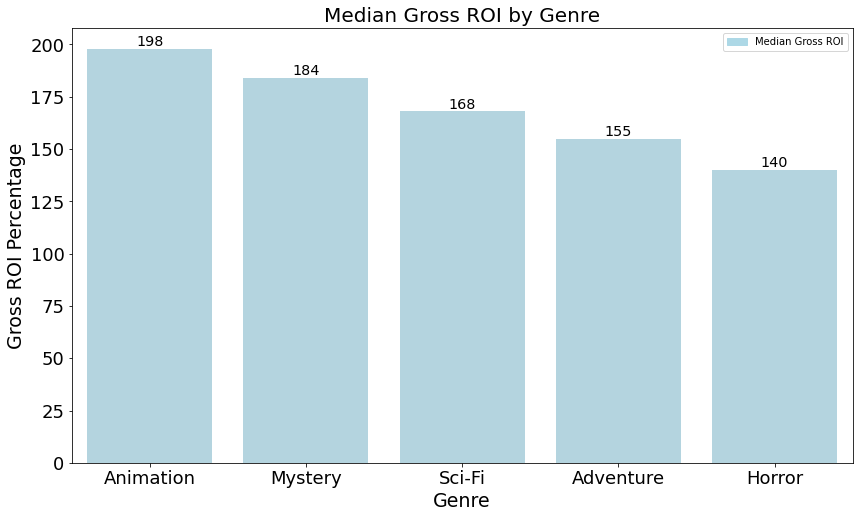

In [4317]:
plt.figure(figsize=(14, 8))

ax1 = sns.barplot(x="genre",  y='gross_roi', data=genre_roi_df, color='lightblue')


# add legend
bar = mpatches.Patch(color='lightblue', label='Median Gross ROI')
plt.legend(handles=[bar])

for index, row in genre_roi_df.iterrows():
    ax1.text(row.name, row['gross_roi'], row['gross_roi'], color='black', ha="center",
             fontsize='x-large',va='bottom')

# show the graph
plt.title("Median Gross ROI by Genre",fontsize=20)
plt.xlabel('Genre',fontsize=19)
plt.ylabel('Gross ROI Percentage',fontsize=19)
plt.tick_params(axis='x',labelsize=18)
plt.tick_params(axis='y',labelsize=18)
plt.show()


#Used stackoverflow example to see how to do the labeling on the bar graph as well as the legend.
#(https://stackoverflow.com/questions/43214978/how-to-display-custom-values-on-a-bar-plot)
#(https://stackoverflow.com/questions/65272126/seaborn-how-to-add-legend-to-seaborn-barplot)

### Month vs. ROI

In [4318]:
month_df = combined_df[['movie', 'gross_roi', 'month']]

In [4319]:
month_df = combined_df.drop_duplicates()

In [4320]:
month_roi_df = month_df.groupby('month')[['gross_roi']].median().reset_index()

In [4321]:
month_roi_df = month_roi_df[['month','gross_roi']].sort_values(by='gross_roi',ascending=False).reset_index(
                                                                                                drop=True).head()

In [4322]:
month_roi_df['gross_roi'] = month_roi_df['gross_roi'].apply(lambda x: round(x))

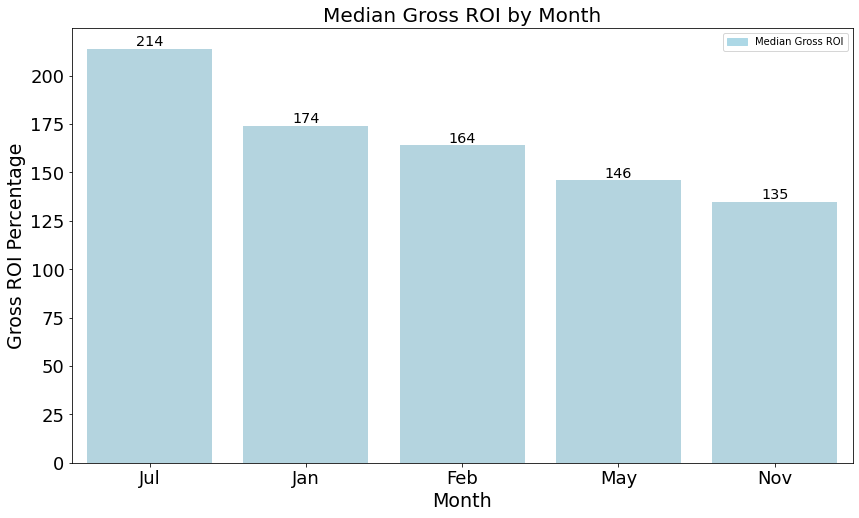

In [4323]:
plt.figure(figsize=(14, 8))

ax1 = sns.barplot(x="month",  y='gross_roi', data=month_roi_df, color='lightblue')


# add legend
bar = mpatches.Patch(color='lightblue', label='Median Gross ROI')
plt.legend(handles=[bar])

for index, row in month_roi_df.iterrows():
    ax1.text(row.name, row['gross_roi'], row['gross_roi'], color='black', ha="center",
             fontsize='x-large',va='bottom')

# show the graph
plt.title("Median Gross ROI by Month",fontsize=20)
plt.xlabel('Month',fontsize=19)
plt.ylabel('Gross ROI Percentage',fontsize=19)
plt.tick_params(axis='x',labelsize=18)
plt.tick_params(axis='y',labelsize=18)
plt.show()


#Used stackoverflow example to see how to do the labeling on the bar graph as well as the legend.
#(https://stackoverflow.com/questions/43214978/how-to-display-custom-values-on-a-bar-plot)
#(https://stackoverflow.com/questions/65272126/seaborn-how-to-add-legend-to-seaborn-barplot)

### Directors vs. ROI

In [4269]:
director_roi_df = combined_df[['movie','primary_name','gross_roi']]

In [4270]:
director_roi_df = director_roi_df.groupby('primary_name')[['gross_roi', 'movie']].agg({'gross_roi':'median',
                                                                                       'movie':'count'}).sort_values(by='gross_roi',
                                                        ascending=False)

In [4271]:
director_roi_df = director_roi_df[director_roi_df['movie']>=5].head(10).reset_index()

In [4272]:
director_roi_df['gross_roi'] = director_roi_df['gross_roi'].apply(lambda x: round(x))

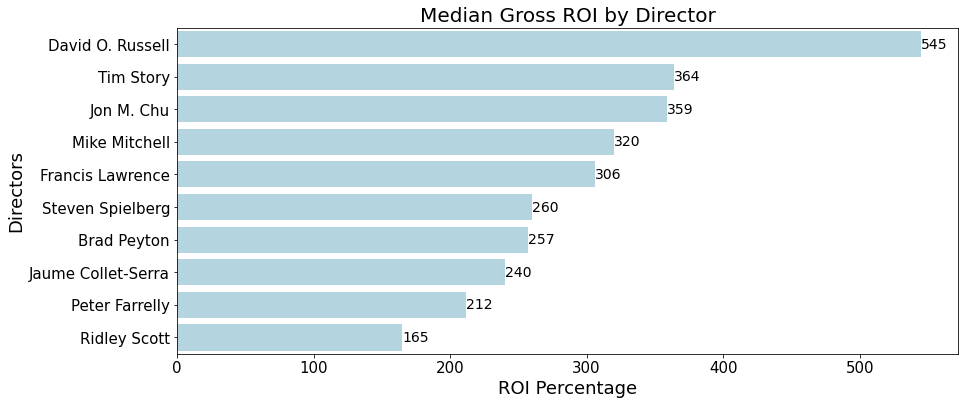

In [4273]:
plt.figure(figsize=(14, 6))

ax1 = sns.barplot(x="gross_roi",  y='primary_name', data=director_roi_df, color='lightblue')

ax1.bar_label(ax1.containers[0],size=14)
# show the graph

plt.title('Median Gross ROI by Director',fontsize=20)
plt.xlabel('ROI Percentage',fontsize=18)
plt.ylabel('Directors',fontsize=18)
plt.tick_params(axis='y',labelsize=15)
plt.tick_params(axis='x',labelsize=15)
plt.show()

#Another way to do bar label that i learned about on stackoverflow.
#(https://stackoverflow.com/questions/49820549/labeling-horizontal-barplot-with-values-in-seaborn)

## Conclusions

### Limitations

### Recommendations

### Next Steps